# Initial Analysis of Recommendations and Upgrades for DBW Project

Last updated: 20 July 2022 by Julia Suter

### Structure of Notebook<a id='top'></a>

[**Welcome to the Playground**](#notebook)

[**Loading the EPC data**](#loading)

[**Recommendations**](#recs)
- [What can the data tell us](#recs_basics)
- [Recommendations over time](#recs_over_time)

[**Upgrades and Upgradability**](#upgradability)
- [What can the data tell us](#upgradability_basics)
- [Upgrade network](#upgrade_network)
- [Transitions](#transitions)

[**Kepler Maps**](#kepler)
- [Geographical and IMD data](#supp_data)
- [Upgradability map](#upgradability_map)
- [Upgradability map by Local Authority](#upgradability_map_LA)
- [Energy efficiency map](#en_eff)
- [Rating difference map](#rating_diff)


## Welcome to the Playground

This notebook demonstrates the initial analysis of recommendations and other EPC data for the DBW project. The actual upgradability model is introduced in another notebook. Consider this a playground.

**Note for reviewer**:
This notebook does not have to be reviewed in much detail. Please just check whether everything runs smoothly.


In [22]:
%load_ext autoreload
%autoreload 2

import asf_core_data
from asf_core_data.pipeline.preprocessing import (
    preprocess_epc_data,
    feature_engineering,
)
from asf_core_data.getters.epc import epc_data
from asf_core_data.getters.supplementary_data.deprivation import imd_data
from asf_core_data.utils.visualisation import easy_plotting, kepler
from asf_core_data.utils.geospatial import data_agglomeration

from development_bank_wales import PROJECT_DIR, Path
from development_bank_wales.pipeline.feature_preparation import (
    recommendations,
    data_aggregation,
)
from development_bank_wales.pipeline.feature_preparation.legacy import upgrades

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keplergl import KeplerGl

from ipywidgets import interact, fixed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the data<a id='loading'></a>
[[back to top]](#top)

When executed the very first time, the EPC data is loaded from S3 and saved in `/outputs/data/`. This takes about 5min. After that, the data will be loaded from the local directory (<30 secs).

In [23]:
output_path = PROJECT_DIR / "outputs/data/wales_epc_with_recs.csv"
fig_output_path = PROJECT_DIR / "outputs/figures/autogenerated/"

if not Path(output_path).is_file():

    print("Loading and preparing the data...")

    wales_df = recommendations.load_epc_certs_and_recs(
        data_path="S3", subset="Wales", n_samples=None, remove_duplicates=False
    )

    wales_df.to_csv(output_path, index=False)

    print("Done!")

else:

    print("Loading the data...")
    wales_df = pd.read_csv(output_path)
    print("Done!")

Loading the data...
Done!


## Recommendations<a id='recs'></a>
[[back to top]](#top)

### What can the data tell us<a id='recs_basics'></a>

There are 41 different default recommendations in the Wales EPC Register. 85% of all records have at least one recommendation.

The auto-generated plots show the relation of different recommendations to various property characteristics, e.g. property type or construction age band. For example, only houses and bungalows ever receive a recommendation for solar water heating. The charts can be polished if ever needed.

In [24]:
unique_recs = [col for col in wales_df.columns if col.startswith("Rec:")]

print(
    "Number of different recommendations:",
    len(unique_recs),
)
round(wales_df["HAS_ANY_RECOM"].value_counts(dropna=False, normalize=True), 2)

Number of different recommendations: 41


True     0.85
False    0.15
Name: HAS_ANY_RECOM, dtype: float64

In [25]:
recs = unique_recs + ["HAS_ANY_RECOM"]


@interact(rec=recs)
def plot_recommendations(rec):
    easy_plotting.plot_subcats_by_other_subcats(
        wales_df,
        "PROPERTY_TYPE",
        rec,
        plotting_colors="copper",
        x_tick_rotation=45,
        figsize=(7,5),
        fig_save_path=fig_output_path,
    )
    easy_plotting.plot_subcats_by_other_subcats(
        wales_df,
        "BUILT_FORM",
        rec,
        plotting_colors="copper",
        x_tick_rotation=45,
        figsize=(7,5),
        fig_save_path=fig_output_path,
    )
    easy_plotting.plot_subcats_by_other_subcats(
        wales_df,
        "CONSTRUCTION_AGE_BAND",
        rec,
        plotting_colors="copper",
        x_tick_rotation=45,
        figsize=(7,5),
        fig_save_path=fig_output_path,
    )
    easy_plotting.plot_subcats_by_other_subcats(
        wales_df,
        "CURRENT_ENERGY_RATING",
        rec,
        plotting_colors="copper",
        x_tick_rotation=45,
        figsize=(7,5),
        fig_save_path=fig_output_path,
    )
    easy_plotting.plot_subcats_by_other_subcats(
        wales_df,
        "LOCAL_AUTHORITY_LABEL",
        rec,
        plotting_colors="copper",
        x_tick_rotation=45,
        figsize=(7,5),
        fig_save_path=fig_output_path,
    )
    easy_plotting.plot_subcats_by_other_subcats(
        wales_df,
        "TENURE",
        rec,
        plotting_colors="copper",
        x_tick_rotation=45,
        figsize=(7,5),
        fig_save_path=fig_output_path,
    )

interactive(children=(Dropdown(description='rec', options=('Rec: Solid floor insulation', 'Rec: Low energy lig…

### Recommendations over Time<a id='recs_over_time'></a>
[[back to top]](#top)

Looking at properties with multiple records over time, we can estimate which upgrades are often carried out and which recommendations are implemented. Note that this only an approximation as we do not hold information for all properties, and only one record for many.

In [26]:
wales_df = wales_df.loc[wales_df["TENURE"] == "owner-occupied"]


latest_wales = epc_data.filter_by_year(
    wales_df.loc[wales_df["N_SAME_UPRN_ENTRIES"] > 1],
    None,
    selection="latest entry",
)
first_wales = epc_data.filter_by_year(
    wales_df.loc[wales_df["N_SAME_UPRN_ENTRIES"] > 1],
    None,
    selection="first entry",
)

In [27]:
for rec in unique_recs:

    first_wales_with_rec = recommendations.check_for_implemented_rec(
        rec, first_wales, latest_wales, identifier="UPRN", keep="first"
    )
    print(round(first_wales_with_rec[rec].value_counts(normalize=True), 2))
    print()

False    0.84
True     0.16
Name: Rec: Solid floor insulation, dtype: float64

True     0.6
False    0.4
Name: Rec: Low energy lighting for all fixed outlets, dtype: float64

True     0.63
False    0.37
Name: Rec: Solar water heating, dtype: float64

False    0.98
True     0.02
Name: Rec: High performance external doors, dtype: float64

True     0.71
False    0.29
Name: Rec: Solar photovoltaic panels, 2.5 kWp, dtype: float64

False    0.86
True     0.14
Name: Rec: Wind turbine, dtype: float64

False    0.8
True     0.2
Name: Rec: Increase loft insulation to 270 mm, dtype: float64

False    0.69
True     0.31
Name: Rec: 50 mm internal or external wall insulation, dtype: float64

False    0.76
True     0.24
Name: Rec: Floor insulation, dtype: float64

False    0.91
True     0.09
Name: Rec: Hot water cylinder thermostat, dtype: float64

False    0.89
True     0.11
Name: Rec: Upgrading heating controls, dtype: float64

False    0.58
True     0.42
Name: Rec: Replace boiler with new condensi

In [28]:
@interact(rec=recs, first_wales=fixed(first_wales), latest_wales=fixed(latest_wales))
def plot_recommendations(rec, first_wales, latest_wales):

    first_wales_with_rec = recommendations.check_for_implemented_rec(
        rec, first_wales, latest_wales, keep="first", identifier="UPRN"
    )

    print(rec)
    print(
        "IMPLEMENTED_" + rec,
    )

    # Only look at samples with this recommendation
    first_wales_with_rec = first_wales_with_rec.loc[first_wales_with_rec[rec]]

    easy_plotting.plot_subcats_by_other_subcats(
        first_wales_with_rec,
        "PROPERTY_TYPE",
        "IMPLEMENTED_" + rec,
        plotting_colors="copper",
        x_tick_rotation=45,
        figsize=(7,5),
        fig_save_path=fig_output_path,
    )
    easy_plotting.plot_subcats_by_other_subcats(
        first_wales_with_rec,
        "BUILT_FORM",
        "IMPLEMENTED_" + rec,
        plotting_colors="copper",
        x_tick_rotation=45,
        figsize=(7,5),
        fig_save_path=fig_output_path,
    )
    easy_plotting.plot_subcats_by_other_subcats(
        first_wales_with_rec,
        "CONSTRUCTION_AGE_BAND",
        "IMPLEMENTED_" + rec,
        plotting_colors="copper",
        x_tick_rotation=45,
        figsize=(7,5),
        fig_save_path=fig_output_path,
    )
    easy_plotting.plot_subcats_by_other_subcats(
        first_wales_with_rec,
        "CURRENT_ENERGY_RATING",
        "IMPLEMENTED_" + rec,
        plotting_colors="copper",
        x_tick_rotation=45,
        figsize=(7,5),
        fig_save_path=fig_output_path,
    )
    easy_plotting.plot_subcats_by_other_subcats(
        first_wales_with_rec,
        "LOCAL_AUTHORITY_LABEL",
        "IMPLEMENTED_" + rec,
        plotting_colors="copper",
        x_tick_rotation=45,
        figsize=(7,5),
        fig_save_path=fig_output_path,
    )

interactive(children=(Dropdown(description='rec', options=('Rec: Solid floor insulation', 'Rec: Low energy lig…

## Upgrades and Upgradability<a id='upgradability'></a>
[[back to top]](#top)


### What can the data tell us <a id='upgradability_basics'></a>
We measure upgradability based on whether a property has had an improvement in a specific category or whether there has been a recommendation.

The most upgrades happen in the category 'lighting' since it's the easiest one. There are hardly any (recorded) upgrades done to the floor of a property, as it is a real hassle.

Mainheat, hot water and lighting are most frequently recommended to be upgraded. When only looking at properties with specific recommendation, then lighting, roof and windows are more frequently upgraded.

In [29]:
first_wales_w_upgrades = upgrades.get_upgrade_features(
    first_wales, latest_wales, keep="first"
)

latest_wales_w_upgrades = upgrades.get_upgrade_features(
    first_wales, latest_wales, keep="latest", verbose=False
)

In [30]:
cats = ["ROOF", "WINDOWS", "WALLS", "FLOOR", "LIGHTING", "HOT_WATER", "MAINHEAT"]


upgrade_df = pd.DataFrame(
    index=cats,
    columns=[
        "Recommendations (%)",
        "Upgrades (%)",
        "Recommendations or Upgrades (%)",
        "Recommendations and Upgrades (%)",
        "Recommendations and Upgrades (% of all with recs)",
        "Upgradability (mean)",
    ],
)
upgrade_df = upgrade_df.astype(float)


for cat in cats:

    total_props = first_wales_w_upgrades.shape[0]
    total_props_with_rec = first_wales_w_upgrades.loc[
        (first_wales_w_upgrades["{}_RECOMMENDATION".format(cat)])
    ].shape[0]
    total_props_with_upgr = first_wales_w_upgrades.loc[
        (first_wales_w_upgrades["{}_EFF_DIFF".format(cat)] > 0)
    ].shape[0]

    props_w_upgr_and_rec = first_wales_w_upgrades.loc[
        (
            (first_wales_w_upgrades["{}_EFF_DIFF".format(cat)] > 0)
            & (first_wales_w_upgrades["{}_RECOMMENDATION".format(cat)])
        )
    ].shape[0]

    props_w_upgr_or_rec = first_wales_w_upgrades.loc[
        (
            (first_wales_w_upgrades["{}_EFF_DIFF".format(cat)] > 0)
            | (first_wales_w_upgrades["{}_RECOMMENDATION".format(cat)])
        )
    ].shape[0]

    first_wales_w_upgrades["{}_UPGRADABILITY".format(cat)] = (
        first_wales_w_upgrades["{}_EFF_DIFF".format(cat)] > 0.0
    ) | (first_wales_w_upgrades["{}_RECOMMENDATION".format(cat)])

    upgrade_dict = {
        "Recommendations (%)": total_props_with_rec / total_props * 100,
        "Upgrades (%)": total_props_with_upgr / total_props * 100,
        "Recommendations or Upgrades (%)": props_w_upgr_or_rec / total_props * 100,
        "Recommendations and Upgrades (%)": props_w_upgr_and_rec / total_props * 100,
        "Recommendations and Upgrades (% of all with recs)": props_w_upgr_and_rec
        / total_props_with_rec
        * 100,
        "Upgradability (mean)": first_wales_w_upgrades[
            "{}_UPGRADABILITY".format(cat)
        ].mean()
        * 100,
    }

    upgrade_df.loc[cat] = pd.Series(upgrade_dict)


upgrade_df = round(upgrade_df)
upgrade_df.head(10)

,Recommendations (%),Upgrades (%),Recommendations or Upgrades (%),Recommendations and Upgrades (%),Recommendations and Upgrades (% of all with recs),Upgradability (mean)
ROOF,24.0,18.0,35.0,7.0,31.0,35.0
WINDOWS,13.0,15.0,25.0,4.0,30.0,25.0
WALLS,48.0,11.0,51.0,8.0,17.0,51.0
FLOOR,42.0,0.0,42.0,0.0,0.0,42.0
LIGHTING,60.0,29.0,67.0,21.0,35.0,67.0
HOT_WATER,66.0,17.0,70.0,13.0,19.0,70.0
MAINHEAT,53.0,11.0,57.0,6.0,12.0,57.0


In [31]:
@interact(
    cat=cats,
    feature=[
        "PROPERTY_TYPE",
        "BUILT_FORM",
        "CONSTRUCTION_AGE_BAND",
        "TRANSACTION_TYPE",
    ],
)
def plotting(cat, feature):
    easy_plotting.plot_subcats_by_other_subcats(
        latest_wales_w_upgrades,
        "UPGRADED_" + cat + "_DESCRIPTION",
        feature,
        plotting_colors="inferno",
        x_tick_rotation=45,
        legend_loc="outside",
        fig_save_path=fig_output_path,
    )

interactive(children=(Dropdown(description='cat', options=('ROOF', 'WINDOWS', 'WALLS', 'FLOOR', 'LIGHTING', 'H…

### Upgrade Network<a id='upgrade_network'></a>
[[back to top]](#top)

This network shows which upgrades often happen at the same time. Of all the properties with any upgrades, 23% have had an upgrade of lighting and roof. 

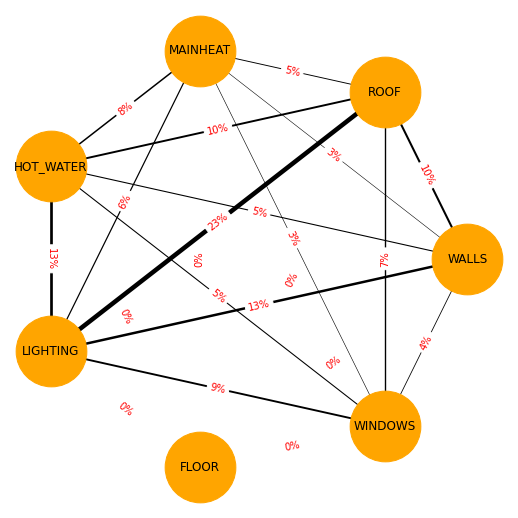

<Figure size 504x504 with 0 Axes>

In [32]:
upgrades.uprade_connections(first_wales_w_upgrades)

## Transitions<a id='transitions'></a>
[[back to top]](#top)

The transitions show the description of a category before and after an upgrade. Not further pursued at the moment.

In [33]:
pd.set_option("display.max_rows", 5000)


@interact(cat=cats)
def get_transitions(cat):
    print(
        round(
            latest_wales_w_upgrades["CHANGE_{}_DESCRIPTION".format(cat)].value_counts(
                normalize=True
            ),
            5,
        )
        * 100
    )

interactive(children=(Dropdown(description='cat', options=('ROOF', 'WINDOWS', 'WALLS', 'FLOOR', 'LIGHTING', 'H…

## Kepler Maps<a id='kepler'></a>
[[back to top]](#top)

Kepler maps showing upgradability, efficiency and rating difference over time. Not used in that form in the final analysis.


### Geographical and IMD Data
<a id='supp_data'></a>
Add geographical data and information about deprivation.

In [34]:
first_wales_suppl = data_aggregation.get_supplementary_data(
    first_wales_w_upgrades, data_path="S3"
)
first_wales_suppl.head()

,LMK_KEY,ADDRESS1,ADDRESS2,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,PROPERTY_TYPE,BUILT_FORM,...,WINDOWS_UPGRADABILITY,WALLS_UPGRADABILITY,FLOOR_UPGRADABILITY,LIGHTING_UPGRADABILITY,HOT_WATER_UPGRADABILITY,MAINHEAT_UPGRADABILITY,LATITUDE,LONGITUDE,hex_id,IMD Decile
0,207726359552009010816482101010358,"1, Nant y Felin",unknown,LL652TQ,3826916568,D,C,60,Bungalow,Detached,...,False,False,False,False,False,False,53.299771,-4.630501,861953077ffffff,3
1,420506275532015051911393697968900,Geufron,Rhosybol,LL689TS,7007931768,C,C,72,Bungalow,Detached,...,False,False,False,False,True,False,53.379154,-4.369292,861953b9fffffff,6
2,957828936732013062416412643278509,Tyn y Buarth,Rhosybol,LL689TS,3933530178,G,C,2,House,Detached,...,False,True,True,True,True,True,53.379154,-4.369292,861953b9fffffff,6
3,1497972309632016112519255945978499,Glangors Fawr,Rhosybol,LL689TS,985458478,F,A,29,Bungalow,Detached,...,False,True,True,True,True,True,53.379154,-4.369292,861953b9fffffff,6
4,1299147397532015032413381850278507,Tide Rip,Ravenspoint,LL652AJ,9710544378,E,C,39,Bungalow,Detached,...,False,True,False,True,False,True,53.269450,-4.622863,861953047ffffff,8


### Upgradability<a id='upgradability_map'></a>
[[back to top]](#top)

In [35]:
kepler_df = data_aggregation.get_aggregated_upgrade_data(first_wales_suppl, "hex_id")

config = kepler.get_config("upgrades.txt", data_path=PROJECT_DIR)
upgrade_map = KeplerGl(height=500, config=config)

upgrade_map.add_data(
    data=kepler_df[["UPGRADABILITY_TOTAL_MEAN", "hex_id"]], name="Total Upgradability"
)

upgrade_map.add_data(
    data=kepler_df[["UPGRADABILITY_ROOF_MEAN", "hex_id"]], name="Roof Upgradability"
)

upgrade_map.add_data(
    data=kepler_df[["UPGRADABILITY_WINDOWS_MEAN", "hex_id"]],
    name="Windows Upgradability",
)

upgrade_map.add_data(
    data=kepler_df[["UPGRADABILITY_MAINHEAT_MEAN", "hex_id"]],
    name="Heating Upgradability",
)

upgrade_map.add_data(
    data=kepler_df[["UPGRADABILITY_LIGHTING_MEAN", "hex_id"]],
    name="Lighting Upgradability",
)

upgrade_map.add_data(
    data=kepler_df[["IMD Decile Hex", "hex_id"]], name="IMD Decile for Hex"
)


upgrade_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'wikkpi', 'type': '…

In [36]:
kepler.save_config(upgrade_map, "upgrades.txt", data_path=PROJECT_DIR)
kepler.save_map(upgrade_map, "Upgrades.html", data_path=PROJECT_DIR)

Map saved to /Users/juliasuter/Documents/repositories/development_bank_wales/outputs/figures/kepler/maps/Upgrades.html!


### Upgradability by Local Authority
<a id='upgradability_map_by_LA'></a>
[[back to top]](#top)

In [37]:
kepler_df = data_aggregation.get_aggregated_upgrade_data(
    first_wales_suppl, "LOCAL_AUTHORITY_LABEL"
)

config = kepler.get_config("LA_upgrades.txt", data_path=PROJECT_DIR)
upgrade_map = KeplerGl(height=500, config=config)

upgrade_map.add_data(
    data=kepler_df[
        ["UPGRADABILITY_TOTAL_MEAN", "MOST_FREQUENT_LOCAL_AUTHORITY_LABEL", "hex_id"]
    ],
    name="Total Upgradability",
)

upgrade_map.add_data(
    data=kepler_df[
        ["UPGRADABILITY_ROOF_MEAN", "MOST_FREQUENT_LOCAL_AUTHORITY_LABEL", "hex_id"]
    ],
    name="Roof Upgradability",
)

upgrade_map.add_data(
    data=kepler_df[
        ["UPGRADABILITY_WINDOWS_MEAN", "MOST_FREQUENT_LOCAL_AUTHORITY_LABEL", "hex_id"]
    ],
    name="Windows Upgradability",
)

upgrade_map.add_data(
    data=kepler_df[
        ["UPGRADABILITY_MAINHEAT_MEAN", "MOST_FREQUENT_LOCAL_AUTHORITY_LABEL", "hex_id"]
    ],
    name="Heating Upgradability",
)

upgrade_map.add_data(
    data=kepler_df[
        ["UPGRADABILITY_LIGHTING_MEAN", "MOST_FREQUENT_LOCAL_AUTHORITY_LABEL", "hex_id"]
    ],
    name="Lighting Upgradability",
)

upgrade_map.add_data(
    data=kepler_df[["IMD Decile Hex", "MOST_FREQUENT_LOCAL_AUTHORITY_LABEL", "hex_id"]],
    name="IMD Decile for Hex",
)

upgrade_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 't18f3uo', 'type': …

In [38]:
kepler.save_config(upgrade_map, "LA_upgrades.txt", data_path=PROJECT_DIR)
kepler.save_map(upgrade_map, "LA_Upgrades.html", data_path=PROJECT_DIR)

Map saved to /Users/juliasuter/Documents/repositories/development_bank_wales/outputs/figures/kepler/maps/LA_Upgrades.html!


## Energy Efficiency
<a id='en_eff'></a>
[[back to top]](#top)

In [39]:
kepler_df = data_aggregation.get_aggregated_upgrade_data(first_wales_suppl, "hex_id")

config = kepler.get_config("efficiencies.txt", data_path=PROJECT_DIR)
upgrade_map = KeplerGl(height=500, config=config)

upgrade_map.add_data(
    data=kepler_df[["TOTAL_ENERGY_EFF_NUM_MEAN", "hex_id"]],
    name="Total Energy Efficiency",
)

upgrade_map.add_data(
    data=kepler_df[["ROOF_ENERGY_EFF_NUM_MEAN", "hex_id"]],
    name="Roof Energy Efficiency",
)

upgrade_map.add_data(
    data=kepler_df[["WINDOWS_ENERGY_EFF_NUM_MEAN", "hex_id"]],
    name="Windows Energy Efficiency",
)

upgrade_map.add_data(
    data=kepler_df[["MAINHEAT_ENERGY_EFF_NUM_MEAN", "hex_id"]],
    name="Heating Energy Efficiency",
)

upgrade_map.add_data(
    data=kepler_df[["LIGHTING_ENERGY_EFF_NUM_MEAN", "hex_id"]],
    name="Lighting Energy Efficiency",
)

upgrade_map.add_data(
    data=kepler_df[["IMD Decile Hex", "hex_id"]], name="IMD Decile for Hex"
)

upgrade_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ou0jw1c', 'type': …

In [40]:
kepler.save_config(upgrade_map, "efficiencies.txt", data_path=PROJECT_DIR)
kepler.save_map(upgrade_map, "Efficiencies.html", data_path=PROJECT_DIR)

Map saved to /Users/juliasuter/Documents/repositories/development_bank_wales/outputs/figures/kepler/maps/Efficiencies.html!


## Rating Diff<a id='rating_diff'></a>
[[back to top]](#top)

In [41]:
kepler_df = data_aggregation.get_aggregated_upgrade_data(first_wales_suppl, "hex_id")

config = kepler.get_config("diffs.txt", data_path=PROJECT_DIR)
upgrade_map = KeplerGl(height=500, config=config)

upgrade_map.add_data(
    data=kepler_df[["TOTAL_EFF_DIFF_MEAN", "hex_id"]], name="Total Upgrades"
)

upgrade_map.add_data(
    data=kepler_df[["ROOF_EFF_DIFF_MEAN", "hex_id"]], name="Roof Upgrades"
)

upgrade_map.add_data(
    data=kepler_df[["WINDOWS_EFF_DIFF_MEAN", "hex_id"]], name="Windows Upgrades"
)


upgrade_map.add_data(
    data=kepler_df[["MAINHEAT_EFF_DIFF_MEAN", "hex_id"]], name="Heating Upgrades"
)

upgrade_map.add_data(
    data=kepler_df[["LIGHTING_EFF_DIFF_MEAN", "hex_id"]], name="Lighting Upgrades"
)

upgrade_map.add_data(
    data=kepler_df[["IMD Decile Hex", "hex_id"]], name="IMD Decile for Hex"
)
upgrade_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'kc4o9wp', 'type': …

In [42]:
kepler.save_config(upgrade_map, "diffs.txt", data_path=PROJECT_DIR)
kepler.save_map(upgrade_map, "Differences.html", data_path=PROJECT_DIR)

Map saved to /Users/juliasuter/Documents/repositories/development_bank_wales/outputs/figures/kepler/maps/Differences.html!
